# Linear Regression on House Price Data using SageMaker
This notebook demonstrates how to train a regression model on house price data using SageMaker's built-in LinearLearner algorithm.

In [ ]:
# Import necessary libraries
import sagemaker
from sagemaker import get_execution_role
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Initialize SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# Define the S3 bucket and prefix for storing data
bucket = sagemaker_session.default_bucket()  # Default bucket created by SageMaker
prefix = 'house-price-linearlearner'  # Prefix for organizing data in S3

print(f"Using bucket: {bucket}")

In [ ]:
# Load the dataset 
df = pd.read_csv('preprocessed.csv')

# Separate features and target
X = df.drop(columns=['saleEstimate_currentPrice'])  # Drop the target column from the features
y = df['saleEstimate_currentPrice']

# Split the data into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

In [ ]:
# Save the datasets to CSV
train_data = pd.concat([y_train, X_train], axis=1)
val_data = pd.concat([y_val, X_val], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

# Save locally
os.makedirs('data', exist_ok=True)
train_data.to_csv('data/train.csv', index=False, header=False)
val_data.to_csv('data/validation.csv', index=False, header=False)
test_data.to_csv('data/test.csv', index=False)

# Upload to S3
train_path = sagemaker_session.upload_data('data/train.csv', bucket=bucket, key_prefix=f'{prefix}/train')
val_path = sagemaker_session.upload_data('data/validation.csv', bucket=bucket, key_prefix=f'{prefix}/validation')
test_path = sagemaker_session.upload_data('data/test.csv', bucket=bucket, key_prefix=f'{prefix}/test')

print(f"Train data uploaded to: {train_path}")
print(f"Validation data uploaded to: {val_path}")

In [ ]:
from sagemaker.estimator import Estimator

# Specify the container image for Linear Learner (built-in algorithm)
linear_learner_container = sagemaker.image_uris.retrieve('linear-learner', sagemaker_session.boto_region_name)

# Define the LinearLearner estimator
linear_estimator = Estimator(
    image_uri=linear_learner_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Set hyperparameters for Linear Learner
linear_estimator.set_hyperparameters(
    predictor_type='regressor',  # We're solving a regression problem
    mini_batch_size=32,
    epochs=10
)

Now we have an instance of the estimator class and we have set the hyperparameters we want to use on the training job. Next we need to call the fit method on this instance to create a SageMaker training job.

Before you run the next cell, make sure you have a browser tab open to the AWS management console as well as this SageMaker Studio JupyterLab tab. Using the sidebar menu navigate to training --> training jobs. From here you will be able to monitor the training job.

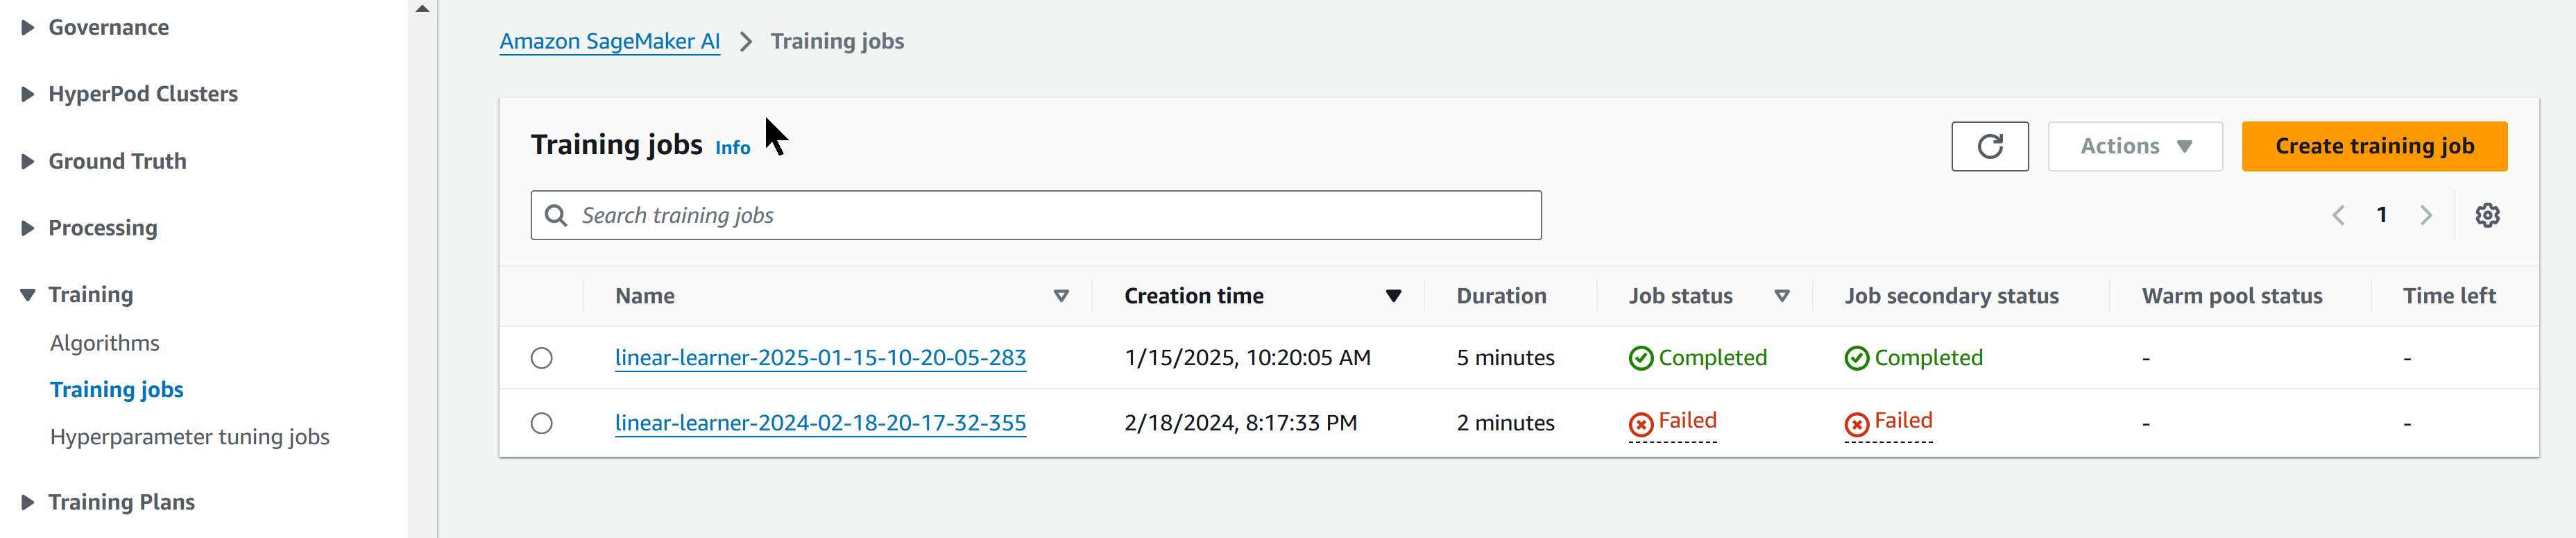

Notice how we are just using the UI to monitor what is being driven by the SageMaker SDK code in a Jupyter notebook cell. This is why trying to learn SageMaker from the UI doesn't work. Now we are in the workflow of a data scientist, we are using the SageMaker platform to abstract infrastructure.

In [ ]:
from sagemaker.inputs import TrainingInput

# Specify the input data channels
train_input = TrainingInput(s3_data=train_path, content_type='text/csv')
val_input = TrainingInput(s3_data=val_path, content_type='text/csv')

# Train the model
linear_estimator.fit({'train': train_input, 'validation': val_input})

Now now we have a trained model! How easy was that?! :-)

In the AWS management console (you will have a tab open to this already in your browser), navigate to the S3 bucket used in this lab. The bucket being used is a console output of the first cell of this notebook. Within that S3 bucket, you can navigate to the path house-price-linearlearner/output/linear-learner-2025-01-15-10-20-05-283/output/ and you will see the model artifact produced by the training job. Note the path name shown here will be different in your environment as the folder name includes the date and time of when the training job ran.

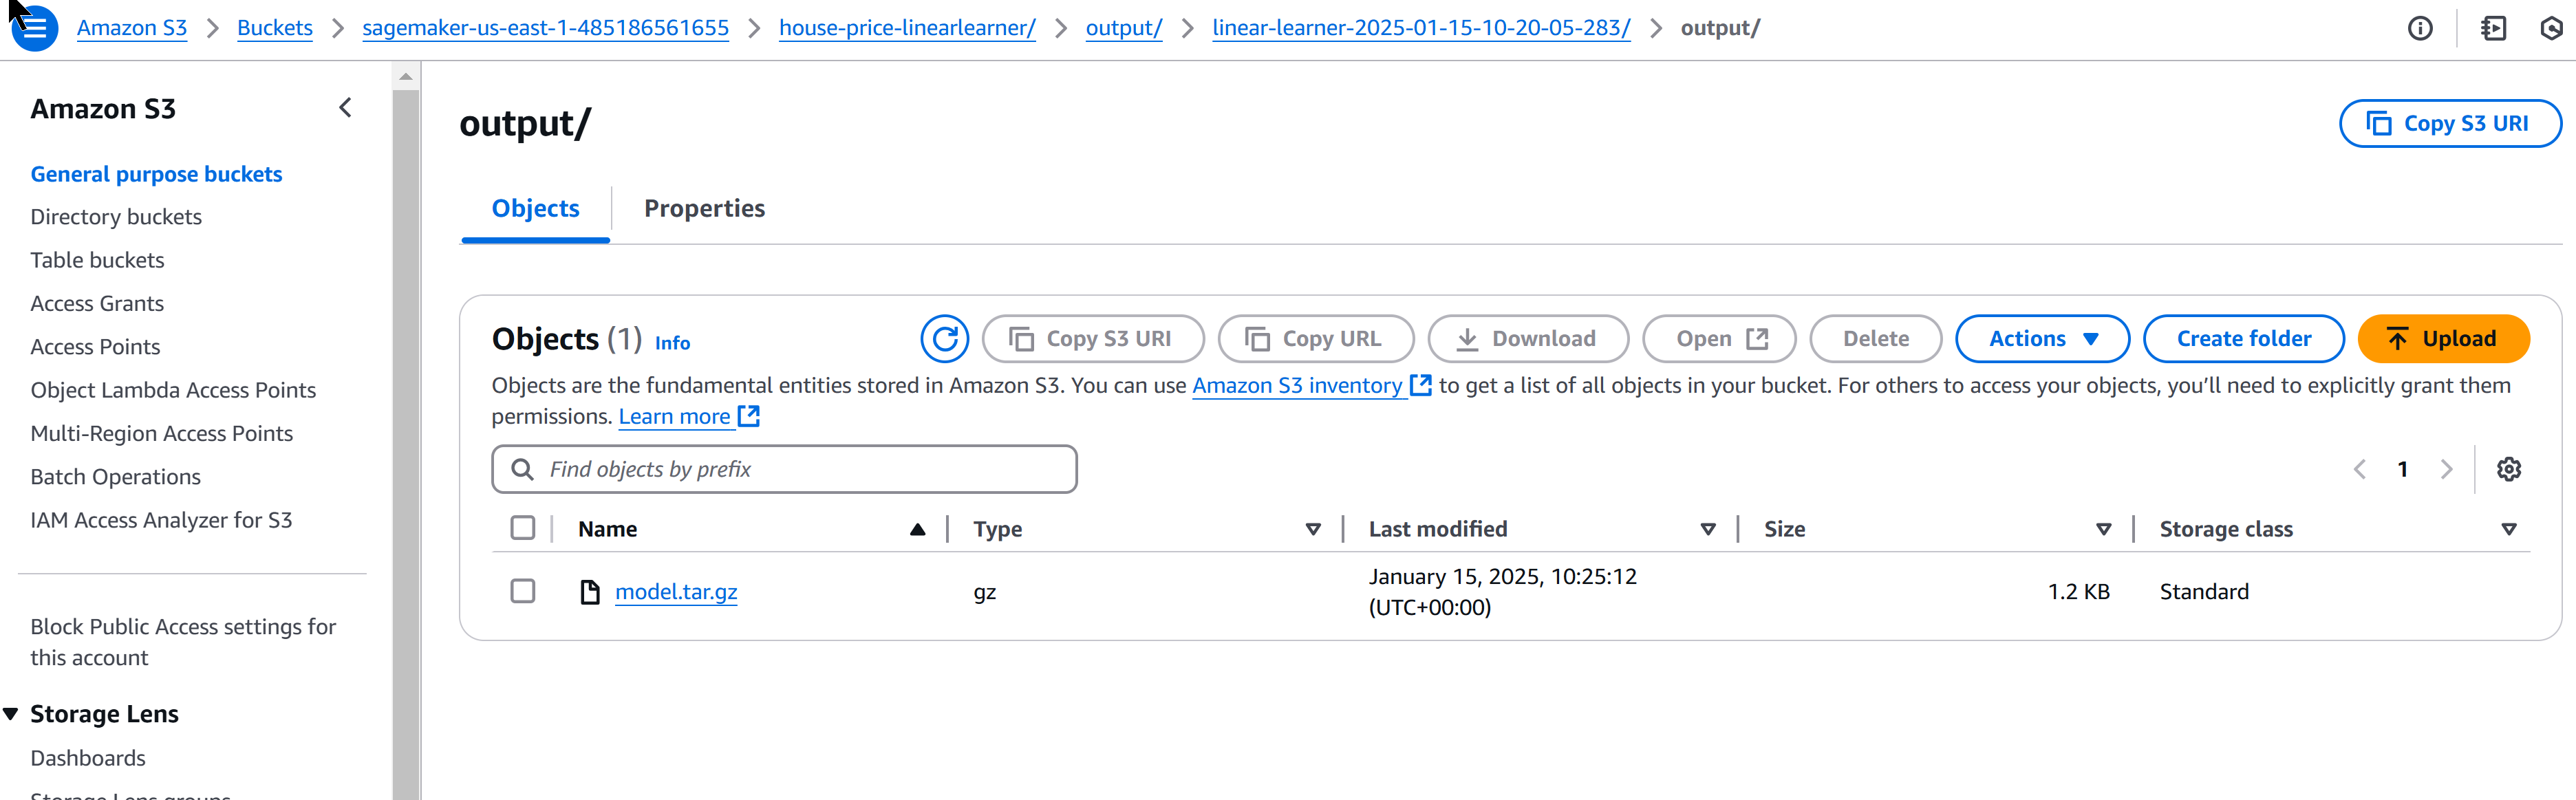

Next we will create an inference endpoint to test our model. We will cover inference endpoints in more detail in upcoming lessons, but for now what we are doing is deploying our model to a hosted endpoint so we can run inference requests against it. That way we can test our hosted model.


In [ ]:
# Deploy the trained model to an endpoint
predictor = linear_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')

So now we have a hosted trained model in SageMaker!

We are going to now use it to send some test inference requests to the model and we will use the predicted house price values on a graphical plot. We are using a common visualization Python library called matplotlib to do this.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Prepare payload in CSV format
payload = "\n".join(",".join(map(str, row)) for row in X_val.values)

# Send the payload to the endpoint
response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})

# Extract predictions from the response
predicted_prices = np.array([float(pred['score']) for pred in json.loads(response.decode('utf-8'))['predictions']])

# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_val, predicted_prices, alpha=0.6, label="Predicted vs Actual")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Residual Plot
residuals = y_val - predicted_prices
plt.figure(figsize=(10, 6))
plt.scatter(y_val, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.show()


Let's make some of the visualization a little clearer to help us understand the predicted values

In [ ]:
# Visualization: Predicted vs Actual Prices with Distinct Styling
plt.figure(figsize=(12, 8))

# Scatter actual prices
plt.scatter(y_val.index, y_val, color='blue', label='Actual Prices', alpha=0.7, marker='o')

# Scatter predicted prices
plt.scatter(y_val.index, predicted_prices, color='red', label='Predicted Prices', alpha=0.7, marker='^')

# Connect actual and predicted prices for each point
for i in range(len(y_val)):
    plt.plot([y_val.index[i], y_val.index[i]], [y_val.iloc[i], predicted_prices[i]], color='gray', alpha=0.5, linestyle='--')

# Add labels and legend
plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Predicted vs. Actual Prices")
plt.legend()
plt.grid(True)

plt.show()


So that wraps up the training process. Notice that we didn't consume any local compute resources, we leveraged SageMaker hosted infrastructure to train our model and then to test our model. We spent our time on tuning the training process and evaluating the results, not on infrastructure related tasks. 

Before we finish up the lab, we need to tidy up our use of resources. The compute instance used for training is already shutdown - that ended when the training job finished. However the hosted model for inference will exist until we decommission it. So make sure you run this last cell of the notebook to delete the SageMaker endpoint.

In [ ]:
# Delete the endpoint to avoid ongoing costs
predictor.delete_endpoint()

This concludes lab 4. You may now shutdown this tab and stop the JupyterLab space.